<a href="https://colab.research.google.com/github/codeplay9800/CIS_580_HW05_3DReconstructionFrom2D/blob/main/%5BCIS580%5Dhomework_05_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
!pip install opencv-contrib-python==4.3.0.38

""" Forces colab to use the correct version of opencv, sets up matlab, imports
"""

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

     |████████████████████████████████| 55.4MB 76kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


image shape: (410, 615, 3)


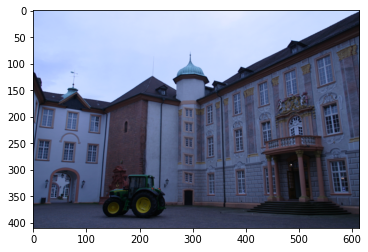

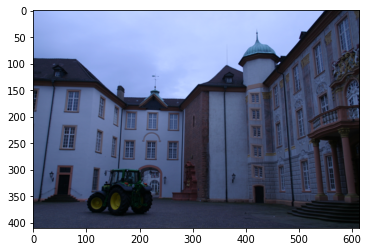

In [57]:
"""  This loads the images.  You must first upload the images to your colab
session.  Each time you start a new session, you will need to upload them again.
"""
im_left = cv2.imread('/content/0014_2.png')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('/content/0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

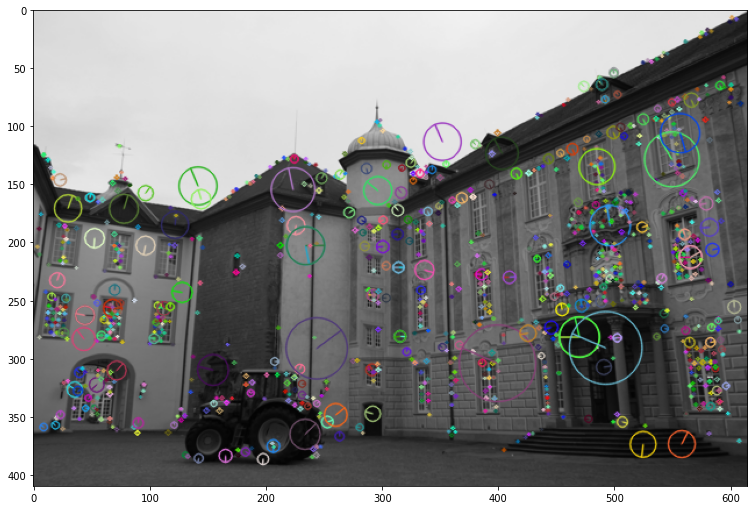

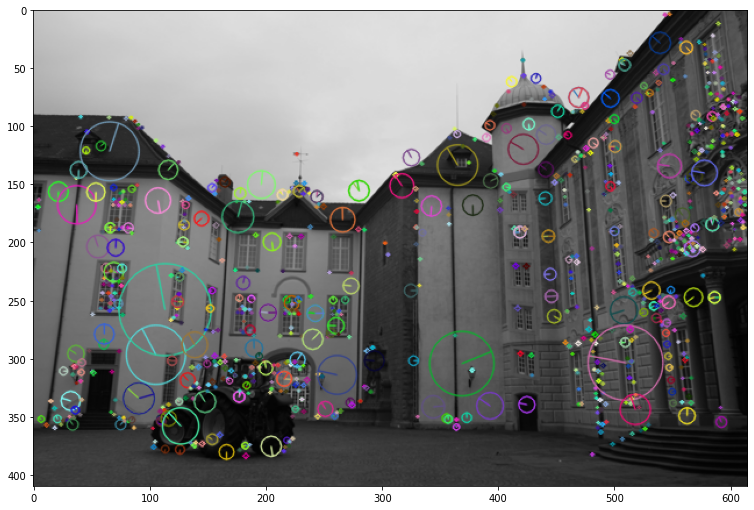

In [58]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 393


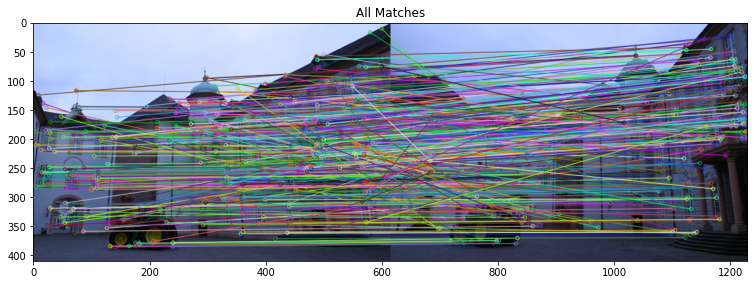

In [59]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)

In [60]:
""" Compute calibrated coordinates
"""
f = 552
u0 = 307.5
v0 = 205

K = np.array([[f, 0, u0],
              [0, f, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T

In [61]:
def least_squares_estimation(X1, X2):
  """ YOUR CODE HERE
  """

  # k = np.array([1, 2, 3])
  # q = np.array([1, 2, 3])
  # H = np.zeros((1, 9))
  # print(H)
  # b =0
  # for x in range(3):
  #   for y in range(3):
  #     H[0][b] = k[x] * q[y]
  #     b = b+1
  # print ("H", H)
  # print("X1", X1.shape)
  N = len(X1)
  A = np.zeros( (N , 9) )
  l=0
  for z in range(N):
    for x in range(3):
      for y in range(3):
        #np.append(A, [X1[z][x] * X2[z][y]], axis=0) 
        A[z][l] = X1[z][x] * X2[z][y]
        #print("A", A)
        l = l+1
    l = 0

  # A = A.reshape(N, 9)
  #print (A)
  u, s, vh = np.linalg.svd(A)
  #print("vh", vh)
  
  v = np.transpose(vh)
  #print ("v", v)
  E = np.zeros( 9 )
  for x in range(9):
    E[x] = v[x][8]

  E = E.reshape(3, 3)
  #print ("E", E)

 
  #print(final_E)
  return E
  """ END YOUR CODE
  """
  #return E
calibrated_12 = np.array([[1,2,3] ,[5,6,7]])
calibrated_22 = np.array([[2,3,4] ,[2,3,4]])

#E_least = least_squares_estimation(calibrated_12, calibrated_22)

E_least = least_squares_estimation(calibrated_1, calibrated_2)


E_ransac [[-0.00690365 -0.34311589  0.0953713 ]
 [ 0.00716154 -0.04908642 -0.70411401]
 [-0.01995367  0.61081465  0.03739186]]
Num inliers (186,)


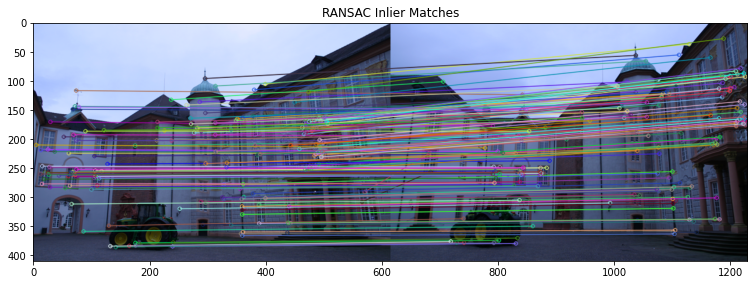

In [62]:

def residualCalculator(x1, x2, E):
  term1 = x1.dot(E.dot(x2))
  e3 = [0, 0, 1]
  e3_skew = np.array([[0, -1, 0], [ 1, 0, 0], [0, 0, 0]]);
  term2 = np.linalg.norm(e3_skew .dot(E .dot(x2)))
  ans = (term1 * term1)/ (term2 * term2)
  return ans

   


def ransac_estimator(X1, X2):
  num_iterations = 20000
  # num_iterations = 5000
  sample_size = 8

  eps = 10**-4

  best_num_inliers = -1
  best_inliers = None
  best_E = None

  for _ in range(num_iterations):
    permuted_indices = np.random.permutation(np.arange(X1.shape[0]))
    sample_indices = permuted_indices[:sample_size]
    test_indices = permuted_indices[sample_size:]
    """ YOUR CODE HERE
    """
    
    sampleX1 = np.empty((sample_size, 3))
    sampleX2 = np.empty((sample_size, 3))
    for x in range(sample_size):
      sampleX1[x] = X1[sample_indices[x]]
      sampleX2[x] = X2[sample_indices[x]]

    E = least_squares_estimation(sampleX1, sampleX2)

    # testx1 = X1[test_indices[50]]
    # testx2 = X2[test_indices[50]]
    # A = residualCalculator(testx1.reshape(1,3), testx2, E)
    # print("A", A)
    inliers = []
    e3 = [0, 0, 1]
    e3_skew = np.array([[0, -1, 0], [ 1, 0, 0], [0, 0, 0]]);
    for x in range(len(test_indices)):
      testx1 = X1[test_indices[x]]
      testx2 = X2[test_indices[x]]
      term1 = testx1.reshape(1,3).dot(E.dot(testx2.reshape(3,1)))
      term2 = np.linalg.norm(e3_skew .dot(E .dot(testx2.reshape(3,1))))
      residual_1 = (term1 * term1)/ (term2 * term2)

      term1 = testx2.reshape(1,3).dot(np.transpose(E).dot(testx1.reshape(3,1)))
      term2 = np.linalg.norm(e3_skew .dot(np.transpose(E) .dot(testx2.reshape(3,1))))
      residual_2 = (term1 * term1)/ (term2 * term2)
      A = residual_1 + residual_2
      #A = residualCalculator(testx1.reshape(1,3), testx2.reshape(3,1), E) + residualCalculator(testx2.reshape(1,3), testx1.reshape(3, 1), E) 
      if( A < eps):
        inliers.append(test_indices[x])
    """ END YOUR CODE
    """
    inliers = np.array(inliers)
    
    if inliers.shape[0] > best_num_inliers:
      best_num_inliers = inliers.shape[0]
      best_E = E
      best_inliers = inliers

  return best_E, best_inliers
E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

In [63]:
def plot_lines(lines, h, w):
  """ Utility function to plot lines
  """
  for i in range(lines.shape[1]):
    if abs(lines[0, i] / lines[1, i]) < 1:
      y0 = -lines[2, i] / lines[1, i]
      yw = y0 - w * lines[0, i] / lines[1, i]
      plt.plot([0, w], [y0, yw])
    else:
      x0 = -lines[2, i] / lines[0, i]
      xh = x0 - h * lines[1, i] / lines[0, i]
      plt.plot([x0, xh], [0, h])

qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qshape (3,)
qsha

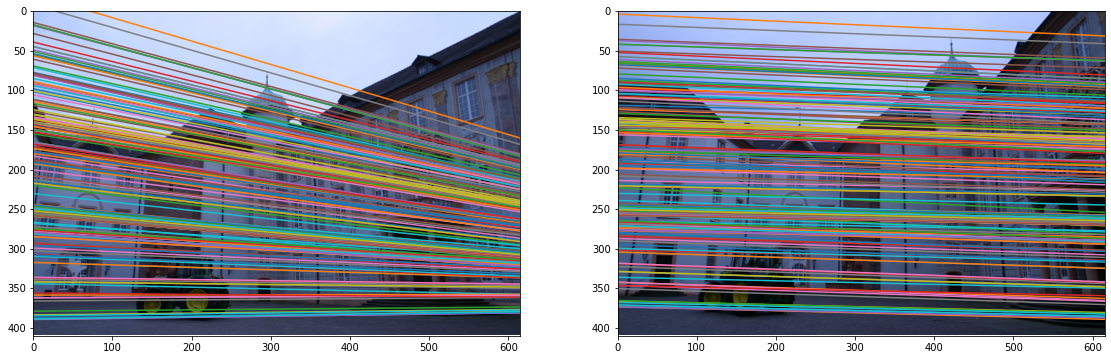

In [99]:
def plot_epipolar_lines(image1, image2, uncalibrated_1, uncalibrated_2, E, K):
  """ Plots the epipolar lines on the images
  """

  """ YOUR CODE HERE
  """

  K_inv = np.linalg.inv(K)
  K_inv_Trans = np.transpose(k_inv)
  F = K_inv_Trans.dot(E.dot(K_inv))

  epipolar_lines_in_1 = np.zeros( (3, len(uncalibrated_1[1])) )
  epipolar_lines_in_2 = np.zeros( (3, len(uncalibrated_2[1])) )
  for x in range(len(uncalibrated_1[1])):
    p = np.array([uncalibrated_1[0][x], uncalibrated_1[1][x], uncalibrated_1[2][x]])
    q = np.array([uncalibrated_2[0][x], uncalibrated_2[1][x], uncalibrated_2[2][x]])
    p_transpose = p.reshape((3,1))
    q_transpose = q.reshape((3,1))
    print ("qshape", q.shape)
    line1 = F.dot(q)
    epipolar_lines_in_1[0][x] = line1[0]
    epipolar_lines_in_1[1][x] = line1[1]
    epipolar_lines_in_1[2][x] = line1[2]

    line2 = np.transpose(F).dot(p)
    epipolar_lines_in_2[0][x] = line2[0]
    epipolar_lines_in_2[1][x] = line2[1]
    epipolar_lines_in_2[2][x] = line2[2]

  """ END YOUR CODE
  """
  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plot_lines(epipolar_lines_in_1, image1.shape[0], image1.shape[1])

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plot_lines(epipolar_lines_in_2, image2.shape[0], image2.shape[1])


uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [97]:
def pose_canidates_from_E(E):
  transform_canidates = []
  """ YOUR CODE HERE
  """
  # u, s, vh = np.linalg.svd(E, full_matrices=True)

  # # print(type(u))
  # print("u", u)
  # print("s", s)
  # print("vh", vh)

  # diag_S = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
  # E = u * diag_S * vh

  u_re, s_re, vh_re = np.linalg.svd(E, full_matrices=True)
  # print(type(u))
  # print("u", u)
  # print("s", s)
  # print("vh", vh)
  E = np.transpose(np.matmul(np.matmul(u_re, np.diag([1,1,0])), vh_re))
  print("E", E)

  # calculate for +T
  u, s, vh = np.linalg.svd(E, full_matrices=True)
  T_pos = np.array([u[0][2], u[1][2], u[2][2]])
  T_neg = np.array([-1 * u[0][2], -1 * u[1][2], -1 * u[2][2]])
  R_interPlus = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
  R_interMinus = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
  R1 = u.dot(R_interPlus.dot(vh))
  R2 = u.dot(R_interMinus.dot(vh))
  
  R1_mul = np.matmul(u , np.matmul(R_interPlus, vh))
  R2_mul = np.matmul(u , np.matmul(R_interMinus, vh))
  
  print ("R1", R1)
  print ("R2", R2)

  print ("R1_mul", R1_mul)
  print ("R2_mul", R2_mul)

  canidate1 = {}
  canidate1['T'] = T_pos
  canidate1['R'] = R1
  transform_canidates.append(canidate1)

  canidate2 = {}
  canidate2['T'] = T_pos
  canidate2['R'] = R2
  transform_canidates.append(canidate2)

  canidate3 = {}
  canidate3['T'] = T_neg
  canidate3['R'] = R1
  transform_canidates.append(canidate3)

  canidate4 = {}
  canidate4['T'] = T_neg
  canidate4['R'] = R2
  transform_canidates.append(canidate4)


  # T = np.array([-1 * u[0][2], -1 * u[1][2], -1 * u[2][2]])
  # print ("T", T)
  # canidate['T'] = T
  # canidate['R'] = R1
  # transform_canidates.append(canidate)

  # canidate['T'] = T
  # canidate['R'] = R2
  # transform_canidates.append(canidate)

  """ END YOUR CODE
  """
  return transform_canidates



transform_canidates = pose_canidates_from_E(E_ransac)
print("transform_canidates", transform_canidates)

E [[ 0.00813606  0.01253387 -0.017788  ]
 [-0.49190475 -0.04514266  0.86924705]
 [ 0.14641278 -0.98866026  0.03123944]]
R1 [[ 0.86669774  0.1233582   0.48334024]
 [-0.12908285  0.99139938 -0.02156127]
 [-0.48184297 -0.04370384  0.87516703]]
R2 [[ 0.84926183  0.16191321  0.50253205]
 [ 0.16347233 -0.98568227  0.04131909]
 [ 0.50202704  0.04705936 -0.86357065]]
R1_mul [[ 0.86669774  0.1233582   0.48334024]
 [-0.12908285  0.99139938 -0.02156127]
 [-0.48184297 -0.04370384  0.87516703]]
R2_mul [[ 0.84926183  0.16191321  0.50253205]
 [ 0.16347233 -0.98568227  0.04131909]
 [ 0.50202704  0.04705936 -0.86357065]]
transform_canidates [{'T': array([0.99973011, 0.02003555, 0.01175938]), 'R': array([[ 0.86669774,  0.1233582 ,  0.48334024],
       [-0.12908285,  0.99139938, -0.02156127],
       [-0.48184297, -0.04370384,  0.87516703]])}, {'T': array([0.99973011, 0.02003555, 0.01175938]), 'R': array([[ 0.84926183,  0.16191321,  0.50253205],
       [ 0.16347233, -0.98568227,  0.04131909],
       [ 0.5

In [93]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_xlim([-2, 2])
  ax.set_ylim([-1, 5])
  ax.set_ylabel('z')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')

calibrated_1.shape[0] 393
best 21 (393,)
not best 0
best 371 (393,)
not best 0


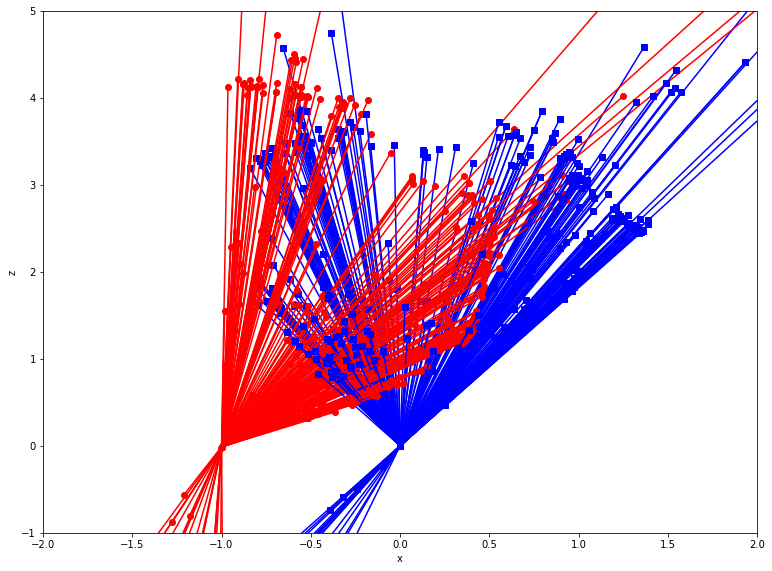

In [98]:
def reconstruct3D(transform_canidates, calibrated_1, calibrated_2):
  """This functions selects (T,R) among the 4 candidates transform_candidates
  such that all triangulated points are in front of both cameras.
  """
  print("calibrated_1.shape[0]",calibrated_1.shape[0])
  best_num_front = -1
  best_canidate = None
  best_lambdas = None
  for canidate in transform_canidates:
    R = canidate['R']
    T = canidate['T']

    lambdas = np.zeros((2, calibrated_1.shape[0]))
    """ YOUR CODE HERE
    """
    for x in range(calibrated_1.shape[0]):
      A = np.array([[1, 2, 3], [3, 4, 5]])
      # print ("A", A.shape)
      # print("Dot Product", R.dot(calibrated_1[x].reshape(3, 1)).shape)
      q = calibrated_2[x].reshape(3, 1)
      
      Rp = -1 * R.dot(calibrated_1[x].reshape(3, 1))
      LHS = np.array([[q[0][0], Rp[0][0]], [q[1][0], Rp[1][0]], [q[2][0], Rp[2][0]]])
      # print ("p", p)
      # print ("q", q)
      #print("LHS", LHS)
      Ans = (np.linalg.pinv(LHS)).dot(T)
      #print("ANs", Ans)
      # print ("Ans.Shape", Ans[0], Ans[1])
      lambdas[0][x] = Ans[1]
      lambdas[1][x] = Ans[0]
    """ END YOUR CODE
    """
    num_front = np.sum(np.logical_and(lambdas[0]>0, lambdas[1]>0))

    if num_front > best_num_front:
      best_num_front = num_front
      best_canidate = canidate
      best_lambdas = lambdas
      print("best", num_front, best_lambdas[0].shape)
    else:
      print("not best", num_front)


  P1 = best_lambdas[1].reshape(-1, 1) * calibrated_1
  P2 = best_lambdas[0].reshape(-1, 1) * calibrated_2
  T = best_canidate['T']
  R = best_canidate['R']
  return P1, P2, T, R


P1, P2, T, R = reconstruct3D(transform_canidates, calibrated_1, calibrated_2)


plot_reconstruction(P1, P2, T, R)

uncalibrated_1 (3, 393)
p [[2.84570048e+05]
 [2.01488529e+05]
 [1.00000000e+00]]
T [-0.99973011 -0.02003555 -0.01175938]
R [[ 0.86669774  0.1233582   0.48334024]
 [-0.12908285  0.99139938 -0.02156127]
 [-0.48184297 -0.04370384  0.87516703]]
final [[ 148.06284387   98.6484565  -264.19480467]
 [ 147.51886492   98.28639547 -263.21511012]
 [ 147.51426954   98.28333688 -263.20683394]]
p [[2.84054190e+04]
 [1.44749775e+05]
 [1.00000000e+00]]
T [[-0.99973011]
 [-0.02003555]
 [-0.01175938]]
R [[ 0.86669774  0.1233582   0.48334024]
 [-0.12908285  0.99139938 -0.02156127]
 [-0.48184297 -0.04370384  0.87516703]]
final [[ 19.69467638  13.49643381 -35.10750874]]
p [[8.98539009e+04]
 [1.19192923e+05]
 [1.00000000e+00]]
T [[-0.99973011]
 [-0.02003555]
 [-0.01175938]]
R [[ 0.86669774  0.1233582   0.48334024]
 [-0.12908285  0.99139938 -0.02156127]
 [-0.48184297 -0.04370384  0.87516703]]
final [[ 48.61214231  32.55593514 -86.72270213]]
p [[3.07618373e+05]
 [1.58178019e+04]
 [1.00000000e+00]]
T [[-0.99973

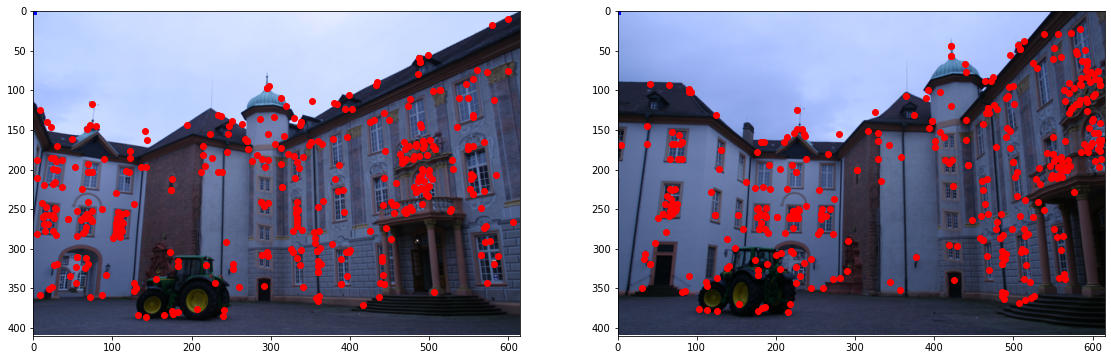

In [92]:
def show_reprojections(image1, image2, uncalibrated_1, uncalibrated_2, P1, P2, K, T, R):

  """ YOUR CODE HERE
  """
  print("uncalibrated_1", uncalibrated_1.shape)
  P2proj = np.zeros(( uncalibrated_1.shape[1], 3))
  P1proj = np.zeros(( uncalibrated_1.shape[1], 3))
  for x in range(uncalibrated_1.shape[1]):
    p = np.array([ [uncalibrated_2[0][x]], [uncalibrated_2[1][x]], [uncalibrated_2[2][x]] ])
    print('p', K.dot(p))
    print('T', T)
    print('R', R)
    print('final', np.matmul(k_inv, R.dot(p) + T).T)
    T = T.reshape(3, 1)
    #print ("shape ", (K.dot(R.dot(p) + T)).shape)
    #P2proj[x] = np.matmul(k_inv, invers(R).dot(p) - inverse(R)(T)).T

  # print("P2proj", P2proj) 
  for x in range(uncalibrated_1.shape[1]):
    q = np.array([ [uncalibrated_1[0][x]], [uncalibrated_1[1][x]], [uncalibrated_1[2][x]] ])
    P1proj[x] = np.matmul(k_inv, R.dot(q) + T).T
  """ END YOUR CODE
  """
  print("P1proj", P1proj)
  # P2proj = np.array([P2proj])

  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plt.plot(P2proj[:, 0] / P2proj[:, 2],
           P2proj[:, 1] / P2proj[:, 2], 'bs')
  plt.plot(uncalibrated_1[0, :], uncalibrated_1[1, :], 'ro')

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plt.plot(P1proj[:, 0] / P1proj[:, 2],
           P1proj[:, 1] / P1proj[:, 2], 'bs')
  plt.plot(uncalibrated_2[0, :], uncalibrated_2[1, :], 'ro')

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)